In [1]:
import numpy as np 
import pandas as pd 
import os
from glob import glob

import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import np_utils
import statsmodels.api as sm

from scipy import stats
from scipy import interp
from itertools import cycle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PoissonRegressor
from sklearn.metrics import mean_squared_error,confusion_matrix, classification_report, roc_curve, auc

import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
#Read and explore the data 
ss = pd.read_csv('../input/feedback-prize-2021/sample_submission.csv')
train=pd.read_csv("../input/feedback-prize-2021/train.csv")
train_txt = glob('../input/feedback-prize-2021/train/*.txt')
test_txt = glob('../input/feedback-prize-2021/test/*.txt')

In [3]:
remove_n = 1
drop_indices = np.random.choice(train.index, remove_n, replace=False)
train = train.drop(drop_indices)
train.describe()

,discourse_id,discourse_start,discourse_end
count,1.442920e+05,144292.000000,144292.000000
mean,1.618936e+12,959.817107,1200.789178
std,2.491900e+09,921.057424,1010.460515
min,1.614351e+12,0.000000,3.000000
25%,1.616884e+12,277.000000,422.000000
50%,1.618862e+12,685.000000,927.000000
75%,1.621222e+12,1404.000000,1696.000000
max,1.623614e+12,7510.000000,7947.000000


In [4]:
#Text colored by discourse type 
#Code source: https://www.kaggle.com/robikscube/student-writing-competition-twitch?scriptVersionId=82562600&cellId=13
def read_essay(id):
    with open(f'../input/feedback-prize-2021/train/{id}.txt') as f:
        essay = f.read()
    return essay

def text_to_color(essay, discourse_type, predictionstring):
    """
    Takes an entire essay, the discourse type and prediction string.
    Returns highlighted text for the prediction string
    """
    discourse_color_map = {
        'Lead':1, # 1 red
        'Position':2, # 2 green
        'Evidence':3, # 3 yellow
        'Claim':4, # 4 blue
        'Concluding Statement':5, # 5 magenta
        'Counterclaim':6, # 6 cyan
        'Rebuttal': 7, # 7 white
        'None' : 9 # default
    }
    hcolor = discourse_color_map[discourse_type]
    text_index = [int(c) for c in predictionstring.split()]
    text_subset = ' '.join(np.array(essay.split())[text_index])
    
    return f'\033[4{hcolor};30m{text_subset}\033[m'

def get_non_discourse_df(train, essay, id):
    all_pred_strings = ' '.join(train.query('id == @id')['predictionstring'].values)
    all_pred_strings = [int(c) for c in all_pred_strings.split()]
    # [c for c in all_pred_strings

    non_discourse_df = pd.DataFrame(
        [c for c in range(len(essay.split())) if c not in all_pred_strings]
    )
    non_discourse_df.columns = ['predictionstring']
    non_discourse_df['cluster'] = (non_discourse_df['predictionstring'] \
                                       .diff().fillna(1) > 1).cumsum()
    
    non_discourse_strings = []
    for i, d in non_discourse_df.groupby('cluster'):
        pred_string = [str(x) for x in d['predictionstring'].values]
        non_discourse_strings.append(' '.join(pred_string))
    df = pd.DataFrame(non_discourse_strings) \
        .rename(columns={0:'predictionstring'})
    df['discourse_type'] = 'None'
    return df

def get_colored_essay(train, id):
    essay = read_essay(id)
    all_text = ''
    train_subset = train.query('id == @id').copy()
    df = get_non_discourse_df(train, essay, id)
    train_subset = pd.concat([train_subset, df])
    train_subset['first_index'] = train_subset['predictionstring'].str.split(' ') \
        .str[0].astype('int')
    train_subset = train_subset.sort_values('first_index').reset_index(drop=True).copy()
    for i, d in train_subset.iterrows():
        colored_text = text_to_color(essay, d.discourse_type, d.predictionstring)
        all_text += ' ' + colored_text
    return all_text[1:]

all_text = get_colored_essay(train, "423A1CA112E2") #The first id in train 
print(all_text)

Phones Modern humans today are always on their phone. They are always on their phone more than 5 hours a day no stop .All they do is text back and forward and just have group Chats on social media. They even do it while driving. They are some really bad consequences when stuff happens when it comes to a phone. Some certain areas in the United States ban phones from class rooms just because of it. When people have phones, they know about certain apps that they have .Apps like Facebook Twitter Instagram and Snapchat. So like if a friend moves away and you want to be in contact you can still be in contact by posting videos or text messages. People always have different ways how to communicate with a phone. Phones have changed due to our generation. Driving is one of the way how to get around. People always be on their phones while doing it. Which can cause serious Problems. That's why there's a thing that's called no texting while driving. That's a really important thing to remember. Some

In [5]:
# Adding some variables to original set, renamed as data
data = train
data['text'] = pd.Series(data['discourse_text'].str.split())  # add list of text
data['length'] = data['text'].str.len()  # add length var
#data.head()

In [6]:
#data['location']="{:.7f}".format(pd.Series(data['discourse_id']))
data['location'] = data['discourse_id'].map('{:,.1f}'.format)
#data.head()  # cannot use discourse_id as location, the number doesn't indicate order.

In [7]:
# need to add location variable:
 # logic: for each discourse id, assign a number
df2 = data.groupby("id",sort=False).agg(list)

location = [[] for x in range(len(df2.index))]
location

for i in range(len(df2.index)):
    for j in range(len(df2['discourse_id'][i])):
        location[i].append(j)
df2['location'] = location        
df2.head()

df3 = df2.apply(lambda x: x.explode() if x.name in ['discourse_id', 'discourse_start', 
                                              'discourse_end', 'discourse_text','discourse_type',
                                             'discourse_type_num', 'predictionstring', 'text','length','location'] else x)
df3.head()


,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring,text,length,location
id,,,,,,,,,,
423A1CA112E2,1622627660524.0,8.0,229.0,Modern humans today are always on their phone....,Lead,Lead 1,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...,"[Modern, humans, today, are, always, on, their...",44,0
423A1CA112E2,1622627653021.0,230.0,312.0,They are some really bad consequences when stu...,Position,Position 1,45 46 47 48 49 50 51 52 53 54 55 56 57 58 59,"[They, are, some, really, bad, consequences, w...",15,1
423A1CA112E2,1622627671020.0,313.0,401.0,Some certain areas in the United States ban ph...,Evidence,Evidence 1,60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75,"[Some, certain, areas, in, the, United, States...",16,2
423A1CA112E2,1622627696365.0,402.0,758.0,"When people have phones, they know about certa...",Evidence,Evidence 2,76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...,"[When, people, have, phones,, they, know, abou...",63,3
423A1CA112E2,1622627759780.0,759.0,886.0,Driving is one of the way how to get around. P...,Claim,Claim 1,139 140 141 142 143 144 145 146 147 148 149 15...,"[Driving, is, one, of, the, way, how, to, get,...",24,4


In [8]:
train_text_combined=train.groupby("discourse_type")["discourse_text"].apply("".join).reset_index()
objs_ori = train_text_combined['discourse_text'].to_list()
train_text_combined

,discourse_type,discourse_text
0,Claim,Driving is one of the way how to get around. P...
1,Concluding Statement,The news always updated when people do somethi...
2,Counterclaim,Conversely people may believe that laws in pre...
3,Evidence,Some certain areas in the United States ban ph...
4,Lead,Modern humans today are always on their phone....
5,Position,They are some really bad consequences when stu...
6,Rebuttal,The problem becomes apparent that this is a se...


In [9]:
train_text_combined['text'] = pd.Series(train_text_combined['discourse_text'].str.split()) 
train_text_combined

,discourse_type,discourse_text,text
0,Claim,Driving is one of the way how to get around. P...,"[Driving, is, one, of, the, way, how, to, get,..."
1,Concluding Statement,The news always updated when people do somethi...,"[The, news, always, updated, when, people, do,..."
2,Counterclaim,Conversely people may believe that laws in pre...,"[Conversely, people, may, believe, that, laws,..."
3,Evidence,Some certain areas in the United States ban ph...,"[Some, certain, areas, in, the, United, States..."
4,Lead,Modern humans today are always on their phone....,"[Modern, humans, today, are, always, on, their..."
5,Position,They are some really bad consequences when stu...,"[They, are, some, really, bad, consequences, w..."
6,Rebuttal,The problem becomes apparent that this is a se...,"[The, problem, becomes, apparent, that, this, ..."


In [10]:
def word_count(words):
    counts = dict()
    
    word_list = []
    for word in words:  #added filter to remove all non-alphabetical characters
        word1 = list(word)
        word2=list(filter(lambda c: c.isalpha(), word1))
        word3 = ''.join(word2)
        word_list.append(word3)
        
    for r in word_list:    
        if r in counts:
            counts[r] += 1
        else:
            counts[r] = 1

    return counts

In [11]:
#Calculates the frequency of each word in a discourse type and stores it as list of dictionaries
freq=[]
for i in range(len(train_text_combined["text"])):
    freq.append(word_count(train_text_combined["text"][i])) 

In [12]:
 #We need to filter out the fillers before frequency or else the top N number of words will be different for each text.
fillers=['the','a','to','an','and','of','that','they','be','you','in','it','are','for','have','students', 'is' ,'can','to','would']

text = train_text_combined['text'].tolist()

filtered = [[] for x in range(len(text))]

for j in range(len(text)):
    for i in range(len(text[j])):
        if text[j][i] not in fillers:
            filtered[j].append(text[j][i])

train_text_combined['filtered'] = filtered            
train_text_combined.head()

,discourse_type,discourse_text,text,filtered
0,Claim,Driving is one of the way how to get around. P...,"[Driving, is, one, of, the, way, how, to, get,...","[Driving, one, way, how, get, around., People,..."
1,Concluding Statement,The news always updated when people do somethi...,"[The, news, always, updated, when, people, do,...","[The, news, always, updated, when, people, do,..."
2,Counterclaim,Conversely people may believe that laws in pre...,"[Conversely, people, may, believe, that, laws,...","[Conversely, people, may, believe, laws, prese..."
3,Evidence,Some certain areas in the United States ban ph...,"[Some, certain, areas, in, the, United, States...","[Some, certain, areas, United, States, ban, ph..."
4,Lead,Modern humans today are always on their phone....,"[Modern, humans, today, are, always, on, their...","[Modern, humans, today, always, on, their, pho..."


In [13]:
#Calculates the frequency of each word in a discourse type and stores it as list of dictionaries
freq=[]
for i in range(len(train_text_combined["filtered"])):
    freq.append(word_count(train_text_combined["filtered"][i])) 

In [14]:
words = []
N = 50
for i in freq:
    result = list(sorted(i, key=i.get, reverse=True)[:N])
    words.append(result)

train_text_combined['words'] = words
train_text_combined.head()

,discourse_type,discourse_text,text,filtered,words
0,Claim,Driving is one of the way how to get around. P...,"[Driving, is, one, of, the, way, how, to, get,...","[Driving, one, way, how, get, around., People,...","[not, on, their, because, people, more, or, wi..."
1,Concluding Statement,The news always updated when people do somethi...,"[The, news, always, updated, when, people, do,...","[The, news, always, updated, when, people, do,...","[not, will, should, people, I, on, more, their..."
2,Counterclaim,Conversely people may believe that laws in pre...,"[Conversely, people, may, believe, that, laws,...","[Conversely, people, may, believe, laws, prese...","[people, not, may, some, their, because, on, s..."
3,Evidence,Some certain areas in the United States ban ph...,"[Some, certain, areas, in, the, United, States...","[Some, certain, areas, United, States, ban, ph...","[on, not, , or, their, people, with, will, I, ..."
4,Lead,Modern humans today are always on their phone....,"[Modern, humans, today, are, always, on, their...","[Modern, humans, today, always, on, their, pho...","[or, people, on, school, not, their, I, do, th..."


In [15]:
# If discourse_type is the same, add words to df3:
#df_temp = train_text_combined['discourse_type','words']
data = [train_text_combined["discourse_type"], train_text_combined["words"]]

headers = ["discourse_type", "words"]

df_temp = pd.concat(data, axis=1, keys=headers)
df_temp.head()

,discourse_type,words
0,Claim,"[not, on, their, because, people, more, or, wi..."
1,Concluding Statement,"[not, will, should, people, I, on, more, their..."
2,Counterclaim,"[people, not, may, some, their, because, on, s..."
3,Evidence,"[on, not, , or, their, people, with, will, I, ..."
4,Lead,"[or, people, on, school, not, their, I, do, th..."


In [16]:
# words for each type
words_claim = df_temp['words'][0] 
words_conc = df_temp['words'][1]  
words_counter = df_temp['words'][2] 
words_evidence = df_temp['words'][3]  
words_lead = df_temp['words'][4]  
words_position =df_temp['words'][5]  
words_rebuttal =df_temp['words'][6]

merged = df3

merged['words_claim'] = [words_claim for _ in range(len(merged))]
merged['words_conc'] = [words_conc for _ in range(len(merged))]
merged['words_counter'] = [words_counter for _ in range(len(merged))]
merged['words_evidence'] = [words_evidence for _ in range(len(merged))]
merged['words_lead'] = [words_lead for _ in range(len(merged))]
merged['words_position'] = [words_position for _ in range(len(merged))]
merged['words_rebuttal'] = [words_rebuttal for _ in range(len(merged))]


merged.head()

,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring,text,length,location,words_claim,words_conc,words_counter,words_evidence,words_lead,words_position,words_rebuttal
id,,,,,,,,,,,,,,,,,
423A1CA112E2,1622627660524.0,8.0,229.0,Modern humans today are always on their phone....,Lead,Lead 1,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...,"[Modern, humans, today, are, always, on, their...",44,0,"[not, on, their, because, people, more, or, wi...","[not, will, should, people, I, on, more, their...","[people, not, may, some, their, because, on, s...","[on, not, , or, their, people, with, will, I, ...","[or, people, on, school, not, their, I, do, th...","[should, I, think, not, people, on, this, from...","[not, but, their, on, this, or, will, do, if, ..."
423A1CA112E2,1622627653021.0,230.0,312.0,They are some really bad consequences when stu...,Position,Position 1,45 46 47 48 49 50 51 52 53 54 55 56 57 58 59,"[They, are, some, really, bad, consequences, w...",15,1,"[not, on, their, because, people, more, or, wi...","[not, will, should, people, I, on, more, their...","[people, not, may, some, their, because, on, s...","[on, not, , or, their, people, with, will, I, ...","[or, people, on, school, not, their, I, do, th...","[should, I, think, not, people, on, this, from...","[not, but, their, on, this, or, will, do, if, ..."
423A1CA112E2,1622627671020.0,313.0,401.0,Some certain areas in the United States ban ph...,Evidence,Evidence 1,60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75,"[Some, certain, areas, in, the, United, States...",16,2,"[not, on, their, because, people, more, or, wi...","[not, will, should, people, I, on, more, their...","[people, not, may, some, their, because, on, s...","[on, not, , or, their, people, with, will, I, ...","[or, people, on, school, not, their, I, do, th...","[should, I, think, not, people, on, this, from...","[not, but, their, on, this, or, will, do, if, ..."
423A1CA112E2,1622627696365.0,402.0,758.0,"When people have phones, they know about certa...",Evidence,Evidence 2,76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...,"[When, people, have, phones,, they, know, abou...",63,3,"[not, on, their, because, people, more, or, wi...","[not, will, should, people, I, on, more, their...","[people, not, may, some, their, because, on, s...","[on, not, , or, their, people, with, will, I, ...","[or, people, on, school, not, their, I, do, th...","[should, I, think, not, people, on, this, from...","[not, but, their, on, this, or, will, do, if, ..."
423A1CA112E2,1622627759780.0,759.0,886.0,Driving is one of the way how to get around. P...,Claim,Claim 1,139 140 141 142 143 144 145 146 147 148 149 15...,"[Driving, is, one, of, the, way, how, to, get,...",24,4,"[not, on, their, because, people, more, or, wi...","[not, will, should, people, I, on, more, their...","[people, not, may, some, their, because, on, s...","[on, not, , or, their, people, with, will, I, ...","[or, people, on, school, not, their, I, do, th...","[should, I, think, not, people, on, this, from...","[not, but, their, on, this, or, will, do, if, ..."


In [17]:
# Score count (counts matches between 2 lists)
def score_count(words,word_list):
    counts = {}
    
    text_list = []
    for word in words:  #added filter to remove all non-alphabetical characters
        word1 = list(word)
        word2 = list(filter(lambda c: c.isalpha(), word1))
        word3 = ''.join(word2)
        text_list.append(word3)
        
    for r in text_list:
        if r in word_list:
            if r in counts:
                counts[r] += 1
            else:
                counts[r] = 1

    return counts

In [18]:
# Scores for each kind of discourse:

# another frequency for matches between words and text columns
score_claim=[]
for i in range(len(merged["text"])):
    score_claim.append(score_count(merged["text"][i],merged['words_claim'][i])) 

score_conc=[]
for i in range(len(merged["text"])):
    score_conc.append(score_count(merged["text"][i],merged['words_conc'][i])) 
    
score_counter=[]
for i in range(len(merged["text"])):
    score_counter.append(score_count(merged["text"][i],merged['words_counter'][i])) 

score_evidence=[]
for i in range(len(merged["text"])):
    score_evidence.append(score_count(merged["text"][i],merged['words_evidence'][i])) 
    
score_lead=[]
for i in range(len(merged["text"])):
    score_lead.append(score_count(merged["text"][i],merged['words_lead'][i])) 
    
score_position=[]
for i in range(len(merged["text"])):
    score_position.append(score_count(merged["text"][i],merged['words_position'][i])) 

score_rebuttal=[]
for i in range(len(merged["text"])):
    score_rebuttal.append(score_count(merged["text"][i],merged['words_rebuttal'][i])) 

In [19]:
sum_claim = []
for i in range(len(score_claim)):
    values = score_claim[i].values()
    sum_claim.append(sum(values))
    
sum_conc = []
for i in range(len(score_conc)):
    values = score_conc[i].values()
    sum_conc.append(sum(values))
    
sum_counter = []
for i in range(len(score_counter)):
    values = score_counter[i].values()
    sum_counter.append(sum(values))
    
sum_evidence = []
for i in range(len(score_evidence)):
    values = score_evidence[i].values()
    sum_evidence.append(sum(values))
    
sum_lead = []
for i in range(len(score_lead)):
    values = score_lead[i].values()
    sum_lead.append(sum(values))
    
sum_position = []
for i in range(len(score_position)):
    values = score_position[i].values()
    sum_position.append(sum(values))
    
sum_rebuttal = []
for i in range(len(score_rebuttal)):
    values = score_rebuttal[i].values()
    sum_rebuttal.append(sum(values))
    
#adding the score to merged
merged["score_claim"]=sum_claim
merged["score_conc"]=sum_conc
merged["score_counter"]=sum_counter
merged["score_evidence"]=sum_evidence
merged["score_lead"]=sum_lead
merged["score_position"]=sum_position
merged["score_rebuttal"]= sum_rebuttal

In [20]:
#adding the score to merged
mapping = {'Claim': 1, 'Concluding Statement': 2, 'Counterclaim':3,'Evidence':4,'Lead':5,'Position':6,'Rebuttal':7}
merged['type'] = [mapping[item] for item in merged['discourse_type']] # This assigns a number to each type.
 
merged.head()

,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring,text,length,location,...,words_position,words_rebuttal,score_claim,score_conc,score_counter,score_evidence,score_lead,score_position,score_rebuttal,type
id,,,,,,,,,,,,,,,,,,,,,
423A1CA112E2,1622627660524.0,8.0,229.0,Modern humans today are always on their phone....,Lead,Lead 1,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...,"[Modern, humans, today, are, always, on, their...",44,0,...,"[should, I, think, not, people, on, this, from...","[not, but, their, on, this, or, will, do, if, ...",10,10,9,10,10,10,12,5
423A1CA112E2,1622627653021.0,230.0,312.0,They are some really bad consequences when stu...,Position,Position 1,45 46 47 48 49 50 51 52 53 54 55 56 57 58 59,"[They, are, some, really, bad, consequences, w...",15,1,...,"[should, I, think, not, people, on, this, from...","[not, but, their, on, this, or, will, do, if, ...",3,0,1,2,1,0,3,6
423A1CA112E2,1622627671020.0,313.0,401.0,Some certain areas in the United States ban ph...,Evidence,Evidence 1,60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75,"[Some, certain, areas, in, the, United, States...",16,2,...,"[should, I, think, not, people, on, this, from...","[not, but, their, on, this, or, will, do, if, ...",3,3,3,3,3,4,3,4
423A1CA112E2,1622627696365.0,402.0,758.0,"When people have phones, they know about certa...",Evidence,Evidence 2,76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...,"[When, people, have, phones,, they, know, abou...",63,3,...,"[should, I, think, not, people, on, this, from...","[not, but, their, on, this, or, will, do, if, ...",8,9,8,9,10,7,9,4
423A1CA112E2,1622627759780.0,759.0,886.0,Driving is one of the way how to get around. P...,Claim,Claim 1,139 140 141 142 143 144 145 146 147 148 149 15...,"[Driving, is, one, of, the, way, how, to, get,...",24,4,...,"[should, I, think, not, people, on, this, from...","[not, but, their, on, this, or, will, do, if, ...",4,5,3,5,5,4,4,1


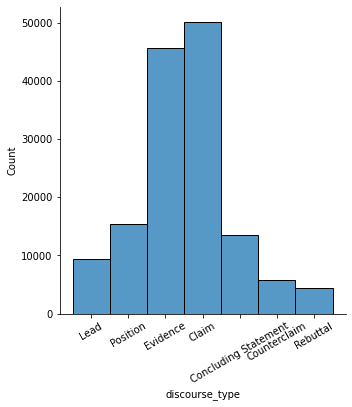

In [21]:
### Variable Distributions
g=sns.displot(merged["discourse_type"]);
g.set_xticklabels(rotation=30);

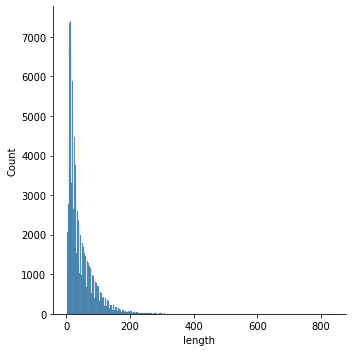

In [22]:
sns.displot(merged["length"]);

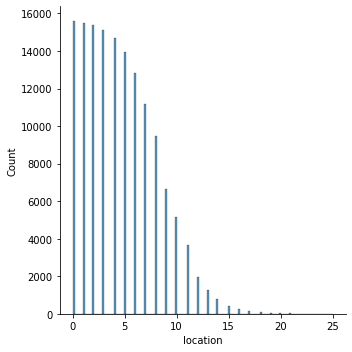

In [23]:
sns.displot(merged["location"]);

In [24]:
X=merged.loc[:,["length","location","score_claim","score_conc","score_counter","score_evidence","score_lead","score_position","score_rebuttal"]]
y=merged["type"]
X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.50,random_state=0)

X_train_tf=np.asarray(X_train).astype('float32')
X_test_tf=np.asarray(X_test).astype('float32')
y_train_tf=np.asarray(y_train)
y_test_tf=np.asarray(y_test)

y_train_tf = np_utils.to_categorical(y_train_tf)
y_train_tf = y_train_tf[:,1:8]

y_test_tf= np_utils.to_categorical(y_test_tf)
y_test_tf = y_test_tf[:,1:8]

In [25]:
#Multi-layer neural net 
input_tensor=keras.Input(shape=(9,))
x1=layers.Dense(7, activation='relu', name="dense_1")(input_tensor)
x2=layers.Dense(7, activation='sigmoid', name="dense_2")(x1)
output_tensor=layers.Dense(1,activation='linear',name='predictions')(x2)

model=keras.Model(inputs=input_tensor,outputs=output_tensor)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),loss=keras.losses.MeanSquaredError(), metrics=[keras.metrics.MeanSquaredError()])

estimator = model.fit(X_train_tf,y_train_tf,epochs=50,batch_size=70)


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

Epoch 1/50
1031/1031 [==============================] - 2s 1ms/step - loss: 0.1533 - mean_squared_error: 0.1533
Epoch 2/50
1031/1031 [==============================] - 1s 1ms/step - loss: 0.1224 - mean_squared_error: 0.1224
Epoch 3/50
1031/1031 [==============================] - 1s 1ms/step - loss: 0.1224 - mean_squared_error: 0.1224
Epoch 4/50
1031/1031 [==============================] - 1s 1ms/step - loss: 0.1224 - mean_squared_error: 0.1224
Epoch 5/50
1031/1031 [==============================] - 1s 1ms/step - loss: 0.1224 - mean_squared_error: 0.1224
Epoch 6/50
1031/1031 [==============================] - 2s 1ms/step - loss: 0.1224 - mean_squared_error: 0.1224
Epoch 7/50
1031/1031 [==============================] - 1s 1ms/step - loss: 0.1224 - mean_squared_error: 0.1224
Epoch 8/50
1031/1031 [==============================] - 1s 1ms/step - loss: 0.1224 - mean_squared_error: 0.1224
Epoch 9/50
1031/1031 [==============================] - 1s 1ms/step - loss: 0.1224 - mean_squared_error:

In [26]:
#Using deep learning model to make predictions in the test set
preds=model.predict(X_test_tf)
nnet_preds=preds*np.std(y_test_tf)+np.mean(y_test_tf)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  app.launch_new_instance()


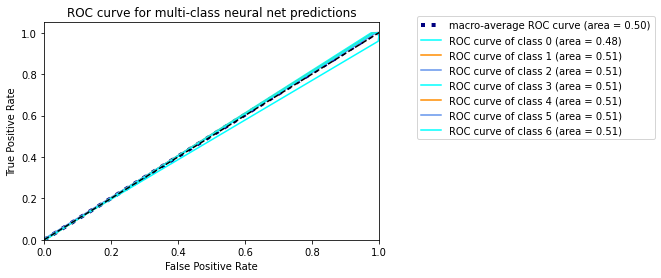

In [27]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes= y_test_tf.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_tf[:, i], nnet_preds)
    roc_auc[i] = auc(fpr[i], tpr[i])
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 3], [0, 3], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve for multi-class neural net predictions")
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()


In [28]:
# GLM Model - Using Poisson GLM because the y variable has different levels that have different probabilities to occur
# picking random 50% of the data to be the training set, 50% to be the test set

freqmodel = PoissonRegressor()
freqmodel.fit(X_train,y_train)
preds_train = freqmodel.predict(X_train)
plt.scatter(preds_train,y_train)
plt.title("Scatterplot for train set")

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_glm/link.py:90: RuntimeWarning: overflow encountered in exp
  return np.exp(lin_pred)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_glm/link.py:93: RuntimeWarning: overflow encountered in exp
  return np.exp(lin_pred)
/opt/conda/lib/python3.7/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: invalid value encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/opt/conda/lib/python3.7/site-packages/sklearn/_loss/glm_distribution.py:315: RuntimeWarning: invalid value encountered in add
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
/opt/conda/lib/python3.7/site-packages/sklearn/_loss/glm_distribution.py:132: RuntimeWarning: overflow encountered in multiply
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
/opt/conda/lib/python3.7/site-packages/sklearn/_loss/glm_distribution.py:315: RuntimeWarning: overflow encountered in multiply
  dev = 2 * (xlogy(y, y/y_pred) 

AttributeError: 'str' object has no attribute 'decode'

In [ ]:
np.corrcoef(preds_train,y_train)

In [ ]:
pois_preds_test = freqmodel.predict(X_test)
plt.scatter(pois_preds_test,y_test)
plt.title("Scatterplot for test set")

In [ ]:
np.corrcoef(pois_preds_test,y_test)

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes= y_test_tf.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_tf[:, i], pois_preds_test)
    roc_auc[i] = auc(fpr[i], tpr[i])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 3], [0, 3], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve for multi-class Poisson regression predictions")
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()